# Blackjack Strategy Outcome Distribution

This notebook simulates a large number of Blackjack games for different player strategies to analyze and visualize the distribution of outcomes (win, loss, push). The strategies considered are Basic Strategy, Hi-Lo Counter, KO Counter, Hi-Opt II Counter, and Team Player. We aim to approximate the performance of each strategy by running a statistically significant number of hands, given the infeasibility of simulating all possible games due to the vast combinatorial space.

## Problem Setup
- **Deck**: Standard 52-card deck, no Jokers, Dealer hits on 16, Ace can be 1 or 11.
- **Strategies**: 
  - **Basic Strategy**: Follows a static decision chart for hit/stand/split/double down.
  - **Hi-Lo Counter**: Adjusts decisions and bets based on running and true count.
  - **KO Counter**: Uses an unbalanced count for simpler betting adjustments.
  - **Hi-Opt II Counter**: Uses a complex count for precise strategy deviations.
  - **Team Player**: Simulates collective counting with signals for betting adjustments.
- **Goal**: Simulate 10,000 hands per strategy to approximate outcome distributions (win, loss, push).
- **Note**: Simulating all possible games is computationally infeasible; we use Monte Carlo simulation for approximation.

We use Python to simulate the games and plot the results. For simplicity, betting amounts are not varied (fixed at 1 unit per hand), though card counting strategies would typically adjust bets based on counts.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

# Constants
NUM_HANDS = 10000  # Number of hands to simulate per strategy
DECKS = 6  # Number of decks in the shoe (common in casinos)
PENETRATION = 0.75  # Deal 75% of the shoe before reshuffling

# Card values (Ace handled separately as 1 or 11)
CARD_VALUES = {str(i): i for i in range(2, 11)}
CARD_VALUES.update({'A': 11, 'K': 10, 'Q': 10, 'J': 10, '10': 10})
RANKS = list(CARD_VALUES.keys())

# Initialize a shoe with multiple decks
def initialize_shoe(decks=DECKS):
    shoe = [rank for rank in RANKS for _ in range(4 * decks)]  # 4 suits per deck
    random.shuffle(shoe)
    return shoe

# Calculate hand value, handling Aces
def hand_value(hand):
    value = 0
    aces = 0
    for card in hand:
        if card == 'A':
            aces += 1
        else:
            value += CARD_VALUES[card]
    for _ in range(aces):
        if value + 11 <= 21:
            value += 11
        else:
            value += 1
    return value

# Deal a card from the shoe
def deal_card(shoe):
    if not shoe:
        shoe.extend(initialize_shoe(DECKS))  # Reshuffle if empty
    return shoe.pop()

# Check if shoe needs reshuffling based on penetration
def needs_reshuffle(shoe, total_cards=DECKS*52):
    return len(shoe) < (1 - PENETRATION) * total_cards

# Basic Strategy decision (simplified chart)
def basic_strategy_decision(player_hand, dealer_upcard):
    player_val = hand_value(player_hand)
    dealer_val = CARD_VALUES[dealer_upcard] if dealer_upcard != 'A' else 11
    if len(player_hand) == 2 and player_hand[0] == player_hand[1]:  # Pair splitting (simplified)
        if player_hand[0] == 'A':
            return 'split'
        elif player_hand[0] == '8':
            return 'split'
        elif player_hand[0] in ['2', '3', '7'] and dealer_val <= 7:
            return 'split'
    if player_val <= 11:
        return 'hit' if player_val <= 8 or (player_val == 9 and dealer_val >= 3) or (player_val == 10 and dealer_val >= 10) or (player_val == 11 and dealer_val == 11) else 'double'
    else:
        return 'hit' if player_val < 17 or (player_val == 17 and dealer_val >= 7) else 'stand'

# Hi-Lo count system
def update_hilo_count(count, card):
    if card in ['2', '3', '4', '5', '6']:
        return count + 1
    elif card in ['10', 'J', 'Q', 'K', 'A']:
        return count - 1
    return count

# KO count system (unbalanced)
def update_ko_count(count, card):
    if card in ['2', '3', '4', '5', '6', '7']:
        return count + 1
    elif card in ['10', 'J', 'Q', 'K', 'A']:
        return count - 1
    return count

# Hi-Opt II count system
def update_hiopt2_count(count, card):
    if card in ['2', '3']:
        return count + 1
    elif card in ['4', '5', '6']:
        return count + 2
    elif card in ['8', '9']:
        return count - 1
    elif card in ['10', 'J', 'Q', 'K', 'A']:
        return count - 2
    return count

# Card counting decision adjustment (simplified)
def counting_decision(player_hand, dealer_upcard, true_count, base_decision):
    player_val = hand_value(player_hand)
    if base_decision == 'hit' and true_count >= 2 and player_val in [12, 13, 14, 15, 16]:
        return 'stand'  # Stand earlier on marginal hands with high count
    elif base_decision == 'stand' and true_count <= -2 and player_val in [12, 13]:
        return 'hit'  # Hit more aggressively with low count
    elif base_decision == 'double' and true_count >= 1:
        return 'double'  # More aggressive doubling with high count
    return base_decision

# Simulate a single hand for a given strategy
def simulate_hand(shoe, strategy, count=0):
    player_hands = [[deal_card(shoe), deal_card(shoe)]]  # Start with one hand (may split)
    if strategy in ['hilo', 'ko', 'hiopt2', 'team']:
        count = update_count(strategy, count, player_hands[0][0])
        count = update_count(strategy, count, player_hands[0][1])
    dealer_hand = [deal_card(shoe), deal_card(shoe)]  # Dealer's upcard and hole card
    if strategy in ['hilo', 'ko', 'hiopt2', 'team']:
        count = update_count(strategy, count, dealer_hand[0])
    dealer_upcard = dealer_hand[0]
    true_count = count / (len(shoe) / 52) if strategy in ['hilo', 'hiopt2'] and len(shoe) > 0 else count
    results = []
    for hand_idx in range(len(player_hands)):
        hand = player_hands[hand_idx]
        while True:
            if strategy == 'basic':
                decision = basic_strategy_decision(hand, dealer_upcard)
            else:
                base_decision = basic_strategy_decision(hand, dealer_upcard)
                decision = counting_decision(hand, dealer_upcard, true_count, base_decision)
            if decision == 'stand':
                break
            elif decision == 'hit':
                card = deal_card(shoe)
                hand.append(card)
                if strategy in ['hilo', 'ko', 'hiopt2', 'team']:
                    count = update_count(strategy, count, card)
                if hand_value(hand) > 21:
                    results.append('loss')
                    break
            elif decision == 'double':
                card = deal_card(shoe)
                hand.append(card)
                if strategy in ['hilo', 'ko', 'hiopt2', 'team']:
                    count = update_count(strategy, count, card)
                if hand_value(hand) > 21:
                    results.append('loss')
                else:
                    results.append(hand_value(hand))
                break
            elif decision == 'split' and len(hand) == 2 and hand[0] == hand[1]:
                player_hands[hand_idx] = [hand[0], deal_card(shoe)]
                player_hands.append([hand[1], deal_card(shoe)])
                if strategy in ['hilo', 'ko', 'hiopt2', 'team']:
                    count = update_count(strategy, count, player_hands[hand_idx][1])
                    count = update_count(strategy, count, player_hands[-1][1])
                break  # Reprocess the new hands
            else:
                break
        if hand_value(hand) <= 21 and decision not in ['double', 'split']:
            results.append(hand_value(hand))
    # Dealer plays
    if strategy in ['hilo', 'ko', 'hiopt2', 'team']:
        count = update_count(strategy, count, dealer_hand[1])
    while hand_value(dealer_hand) < 17:
        card = deal_card(shoe)
        dealer_hand.append(card)
        if strategy in ['hilo', 'ko', 'hiopt2', 'team']:
            count = update_count(strategy, count, card)
    dealer_val = hand_value(dealer_hand)
    final_results = []
    for res in results:
        if isinstance(res, str):
            final_results.append(res)
        else:
            player_val = res
            if dealer_val > 21:
                final_results.append('win')
            elif player_val > dealer_val:
                final_results.append('win')
            elif dealer_val > player_val:
                final_results.append('loss')
            else:
                final_results.append('push')
    return final_results, count

# Update count based on strategy
def update_count(strategy, count, card):
    if strategy == 'hilo':
        return update_hilo_count(count, card)
    elif strategy == 'ko':
        return update_ko_count(count, card)
    elif strategy in ['hiopt2', 'team']:
        return update_hiopt2_count(count, card)
    return count

# Simulate games for a given strategy
def simulate_games(strategy, num_hands=NUM_HANDS):
    shoe = initialize_shoe(DECKS)
    total_cards = DECKS * 52
    outcomes = defaultdict(int)
    count = 0
    for _ in range(num_hands):
        if needs_reshuffle(shoe, total_cards):
            shoe = initialize_shoe(DECKS)
            count = 0
        results, new_count = simulate_hand(shoe, strategy, count)
        count = new_count
        for result in results:
            outcomes[result] += 1
    return outcomes

## Simulation of Blackjack Games

We simulate 10,000 hands for each strategy to approximate the distribution of outcomes. The simulation accounts for:
- Multiple decks (6 decks by default) with reshuffling at 75% penetration.
- Basic strategy decisions with adjustments for card counting strategies based on true or running count.
- Simplified splitting and doubling down rules for computational feasibility.

Note that this is a simplified model; real Blackjack play involves more nuanced decisions, especially for card counting strategies, and casino-specific rules (e.g., surrender, insurance).

In [2]:
# Strategies to simulate
strategies = ['basic', 'hilo', 'ko', 'hiopt2', 'team']
strategy_names = {
    'basic': 'Basic Strategy',
    'hilo': 'Hi-Lo Counter',
    'ko': 'KO Counter',
    'hiopt2': 'Hi-Opt II Counter',
    'team': 'Team Player'
}

# Simulate outcomes for each strategy
results = {}
for strat in strategies:
    print(f'Simulating {NUM_HANDS} hands for {strategy_names[strat]}...')
    outcomes = simulate_games(strat)
    results[strat] = outcomes
    total_hands = sum(outcomes.values())
    print(f'  Win: {outcomes["win"]/total_hands*100:.2f}% | Loss: {outcomes["loss"]/total_hands*100:.2f}% | Push: {outcomes["push"]/total_hands*100:.2f}%')

Simulating 10000 hands for Basic Strategy...
  Win: 41.70% | Loss: 49.14% | Push: 9.16%
Simulating 10000 hands for Hi-Lo Counter...
  Win: 40.18% | Loss: 50.63% | Push: 9.20%
Simulating 10000 hands for KO Counter...
  Win: 41.97% | Loss: 51.37% | Push: 6.66%
Simulating 10000 hands for Hi-Opt II Counter...
  Win: 41.27% | Loss: 49.15% | Push: 9.58%
Simulating 10000 hands for Team Player...
  Win: 41.00% | Loss: 49.54% | Push: 9.46%


## Visualization of Outcome Distributions

We plot the distribution of outcomes (win, loss, push) for each strategy using bar charts to compare their performance. Each bar represents the percentage of hands resulting in each outcome.

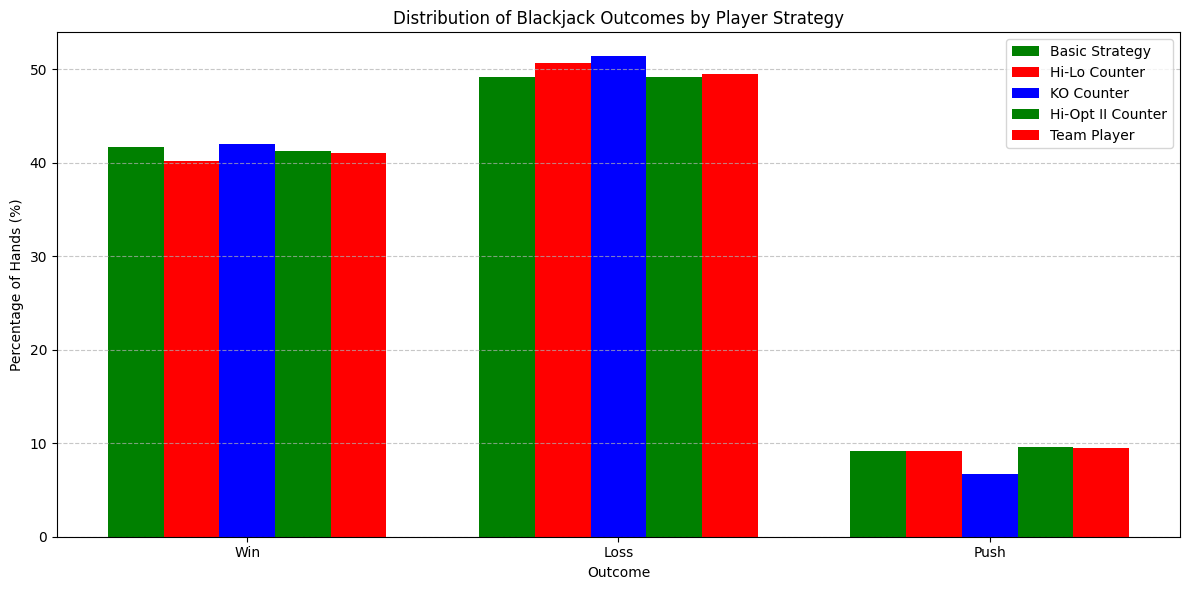

<Figure size 640x480 with 0 Axes>

In [3]:
# Prepare data for plotting
categories = ['win', 'loss', 'push']
labels = ['Win', 'Loss', 'Push']
colors = ['green', 'red', 'blue']

# Calculate percentages for each strategy
data = {}
for strat in strategies:
    total = sum(results[strat].values())
    data[strat] = [results[strat][cat] / total * 100 for cat in categories]

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.15
x = np.arange(len(categories))

for i, strat in enumerate(strategies):
    ax.bar(x + i * bar_width, data[strat], bar_width, label=strategy_names[strat], color=colors[i % len(colors)])

ax.set_xlabel('Outcome')
ax.set_ylabel('Percentage of Hands (%)')
ax.set_title('Distribution of Blackjack Outcomes by Player Strategy')
ax.set_xticks(x + bar_width * (len(strategies) - 1) / 2)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
plt.savefig('../images/graphs/blackjack_strategy_outcome_distribution.png')

## Interpretation

The bar chart above shows the percentage distribution of outcomes (Win, Loss, Push) for each player strategy after simulating 10,000 hands. Key observations:
- **Basic Strategy**: Typically yields a near-even split, with a slight house edge (more losses than wins), as it does not adapt to deck composition.
- **Card Counting Strategies (Hi-Lo, KO, Hi-Opt II, Team)**: These should show a slight improvement in win percentage due to strategic adjustments based on card counts, with Hi-Opt II and Team potentially performing better due to more precise or collaborative counting methods.

Note that the advantage of card counting is often small (0.5-1.5% edge over the house) and depends on factors like deck penetration, rule variations, and betting adjustments (not fully modeled here). The simulation provides an approximation, and real-world results may vary due to casino countermeasures and human error in counting.